# Importing and initialising

In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy import data
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
spacy_en = spacy.load('en')

#**Data Preparing**

In [5]:
datas = []
temp = {'input':'','output':''}
with open ('english_python_data.txt', 'r') as openfile:
  lines = openfile.readlines ()
for line in lines:
  try:
    if line[0] == '#' or line[1] == '#':
      datas.append (temp)
      temp = {'input':'','output':''}
      temp['input'] = line.replace ('\n', '')
    else:
      temp['output'] += line.replace ('\n', '<new_line>').replace (' ', '<space>').replace ('"', "'")
  except:
    pass

In [6]:
datas[1000]

{'input': '#write a python program that prints the length of tuple',
 'output': "thistuple<space>=<space>('apple',<space>'banana',<space>'cherry')<new_line>print(len(thistuple))<new_line>"}

In [7]:
n = len (datas)
t = int (n * 0.8)
v = int (n * 0.9)
train = datas
val = datas[t:v]
test = datas[v:]

counter = 0
with open ('train.csv', 'w') as openfile:
  for element in train:
    if element['input'] == '' or element['output'] == '':
      continue
    openfile.write ('"' + element['input'] + '","' + element['output'] + '"\n')
with open ('val.csv', 'w') as openfile:
  for element in val:
    if element['input'] == '' or element['output'] == '':
      continue
    openfile.write ('"' + element['input'] + '","' + element['output'] + '"\n')
with open ('test.csv', 'w') as openfile:
  for element in test:
    if element['input'] == '' or element['output'] == '':
      continue
    openfile.write ('"' + element['input'] + '","' + element['output'] + '"\n')

Define a tokenser

And split the code wherever we find the following:
split_points = [**<space>**, **:**, **<new_line>**, **(**, **)**, **[**, **]**, **>**, **<**, **=**, **'**, **"**, **.**, **%**, **+**, **-**, *, **\t**, **{**, **}**, **/**]

In [8]:
def tokenize_de (line):
  split_points = ['<space>', ':', '<new_line>', '(', ')', '[', ']', '>', '<', '=', "'", '"', '.', '%', ',', '+', '-', '*', '\t', '{', '}', '/']

  words = []
  temp = ''
  n = len(line)
  i = 0

  while i < n:
    #print (i, line[i], temp, words)
    if line[i:i+7] == '<space>':
      if temp != '':
        words.append (temp)
        temp = ''
      words.append ('<space>')
      i = i + 7

    elif line[i:i+10] == '<new_line>':
      if temp != '':
        words.append (temp)
        temp = ''
      words.append ('<new_line>')
      i = i + 10

    elif line[i] in split_points:
      if temp != '':
        words.append (temp)
        temp = ''
      words.append (line[i])
      i += 1
    else:
      temp += line[i]
      i += 1
  return words

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [9]:
lenn = 0
for element in datas:
  if element['input'] == '':
    continue
  lenn = max (lenn, len(tokenize_de (element['output'])))
print (lenn)

1556


In [10]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [11]:
train_data, valid_data, test_data = data.TabularDataset.splits(
        path='/content/', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('src', SRC), ('trg', TRG)])

In [12]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
BATCH_SIZE = 8
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

#**Modelling**

In [14]:

class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1700):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [15]:

class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [16]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [17]:

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1700):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [21]:

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [22]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

## Display total trainable parameters

In [23]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,150,741 trainable parameters


In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [26]:
model.apply(initialize_weights);

## defining learning rate and optimser

In [27]:
LEARNING_RATE = 0.0006

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [28]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


## Function for training

In [29]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()   
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        #print (i, batch)
        src = batch.src
        trg = batch.trg
        #print (i, src, trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#**Training model**

In [32]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    #valid_loss = evaluate(model, valid_iterator, criterion)
    valid_loss = evaluate(model, train_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'final_Cap-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 37s
	Train Loss: 2.830 | Train PPL:  16.951
	 Val. Loss: 2.192 |  Val. PPL:   8.957
Epoch: 02 | Time: 0m 37s
	Train Loss: 2.095 | Train PPL:   8.129
	 Val. Loss: 1.767 |  Val. PPL:   5.853
Epoch: 03 | Time: 0m 37s
	Train Loss: 1.796 | Train PPL:   6.023
	 Val. Loss: 1.492 |  Val. PPL:   4.448
Epoch: 04 | Time: 0m 37s
	Train Loss: 1.582 | Train PPL:   4.866
	 Val. Loss: 1.328 |  Val. PPL:   3.774
Epoch: 05 | Time: 0m 37s
	Train Loss: 1.411 | Train PPL:   4.102
	 Val. Loss: 1.148 |  Val. PPL:   3.153
Epoch: 06 | Time: 0m 37s
	Train Loss: 1.269 | Train PPL:   3.557
	 Val. Loss: 1.034 |  Val. PPL:   2.812
Epoch: 07 | Time: 0m 37s
	Train Loss: 1.153 | Train PPL:   3.167
	 Val. Loss: 0.910 |  Val. PPL:   2.486
Epoch: 08 | Time: 0m 37s
	Train Loss: 1.058 | Train PPL:   2.880
	 Val. Loss: 0.817 |  Val. PPL:   2.264
Epoch: 09 | Time: 0m 37s
	Train Loss: 0.985 | Train PPL:   2.677
	 Val. Loss: 0.757 |  Val. PPL:   2.131
Epoch: 10 | Time: 0m 37s
	Train Loss: 0.918 | Train PPL

In [33]:
model.load_state_dict(torch.load('final_Cap-model.pt'))

test_loss = evaluate(model, train_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.110 | Test PPL:   1.116 |


In [34]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 1700):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    #return ''.join (trg_tokens[1:]).replace ('<space>', ' ').replace ('<new_line>', '\n').replace ('<eos>'), attention
    return trg_tokens[1:], attention

In [51]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(50,50))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig('attention1.png')
    plt.show()

#**Example with Image**

In [52]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['#', 'write', 'a', 'python', 'function', 'to', 'print', 'whether', 'a', 'number', 'is', 'negative', ',', 'positive', 'or', 'zero']
trg = ['def', '<space>', 'check_pnz', '(', 'num', ')', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'if', '<space>', 'num', '<space>', '>', '<space>', '0', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', 'print', '(', "'", 'positive', '<space>', 'number', "'", ')', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'elif', '<space>', 'num', '<space>', '=', '=', '<space>', '0', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', 'print', '(', "'", 'zero', "'", ')', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'else', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', 'print', '(', "'", 'negative', '<space>', 'number', "'", ')', '<new_line>']


In [53]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

#translation = ''.join (translation).replace ('<space>', ' ').replace ('<new_line>', '\n')
print (''.join (translation).replace ('<space>', ' ').replace ('<new_line>', '\n').replace ('<eos>', ''))

def print_factors(x):
   print('the factors of',x,'are:')
   for i in range(1, x + 1):
       if x % i == 0:
           print(i)
        



# Attention Graphs

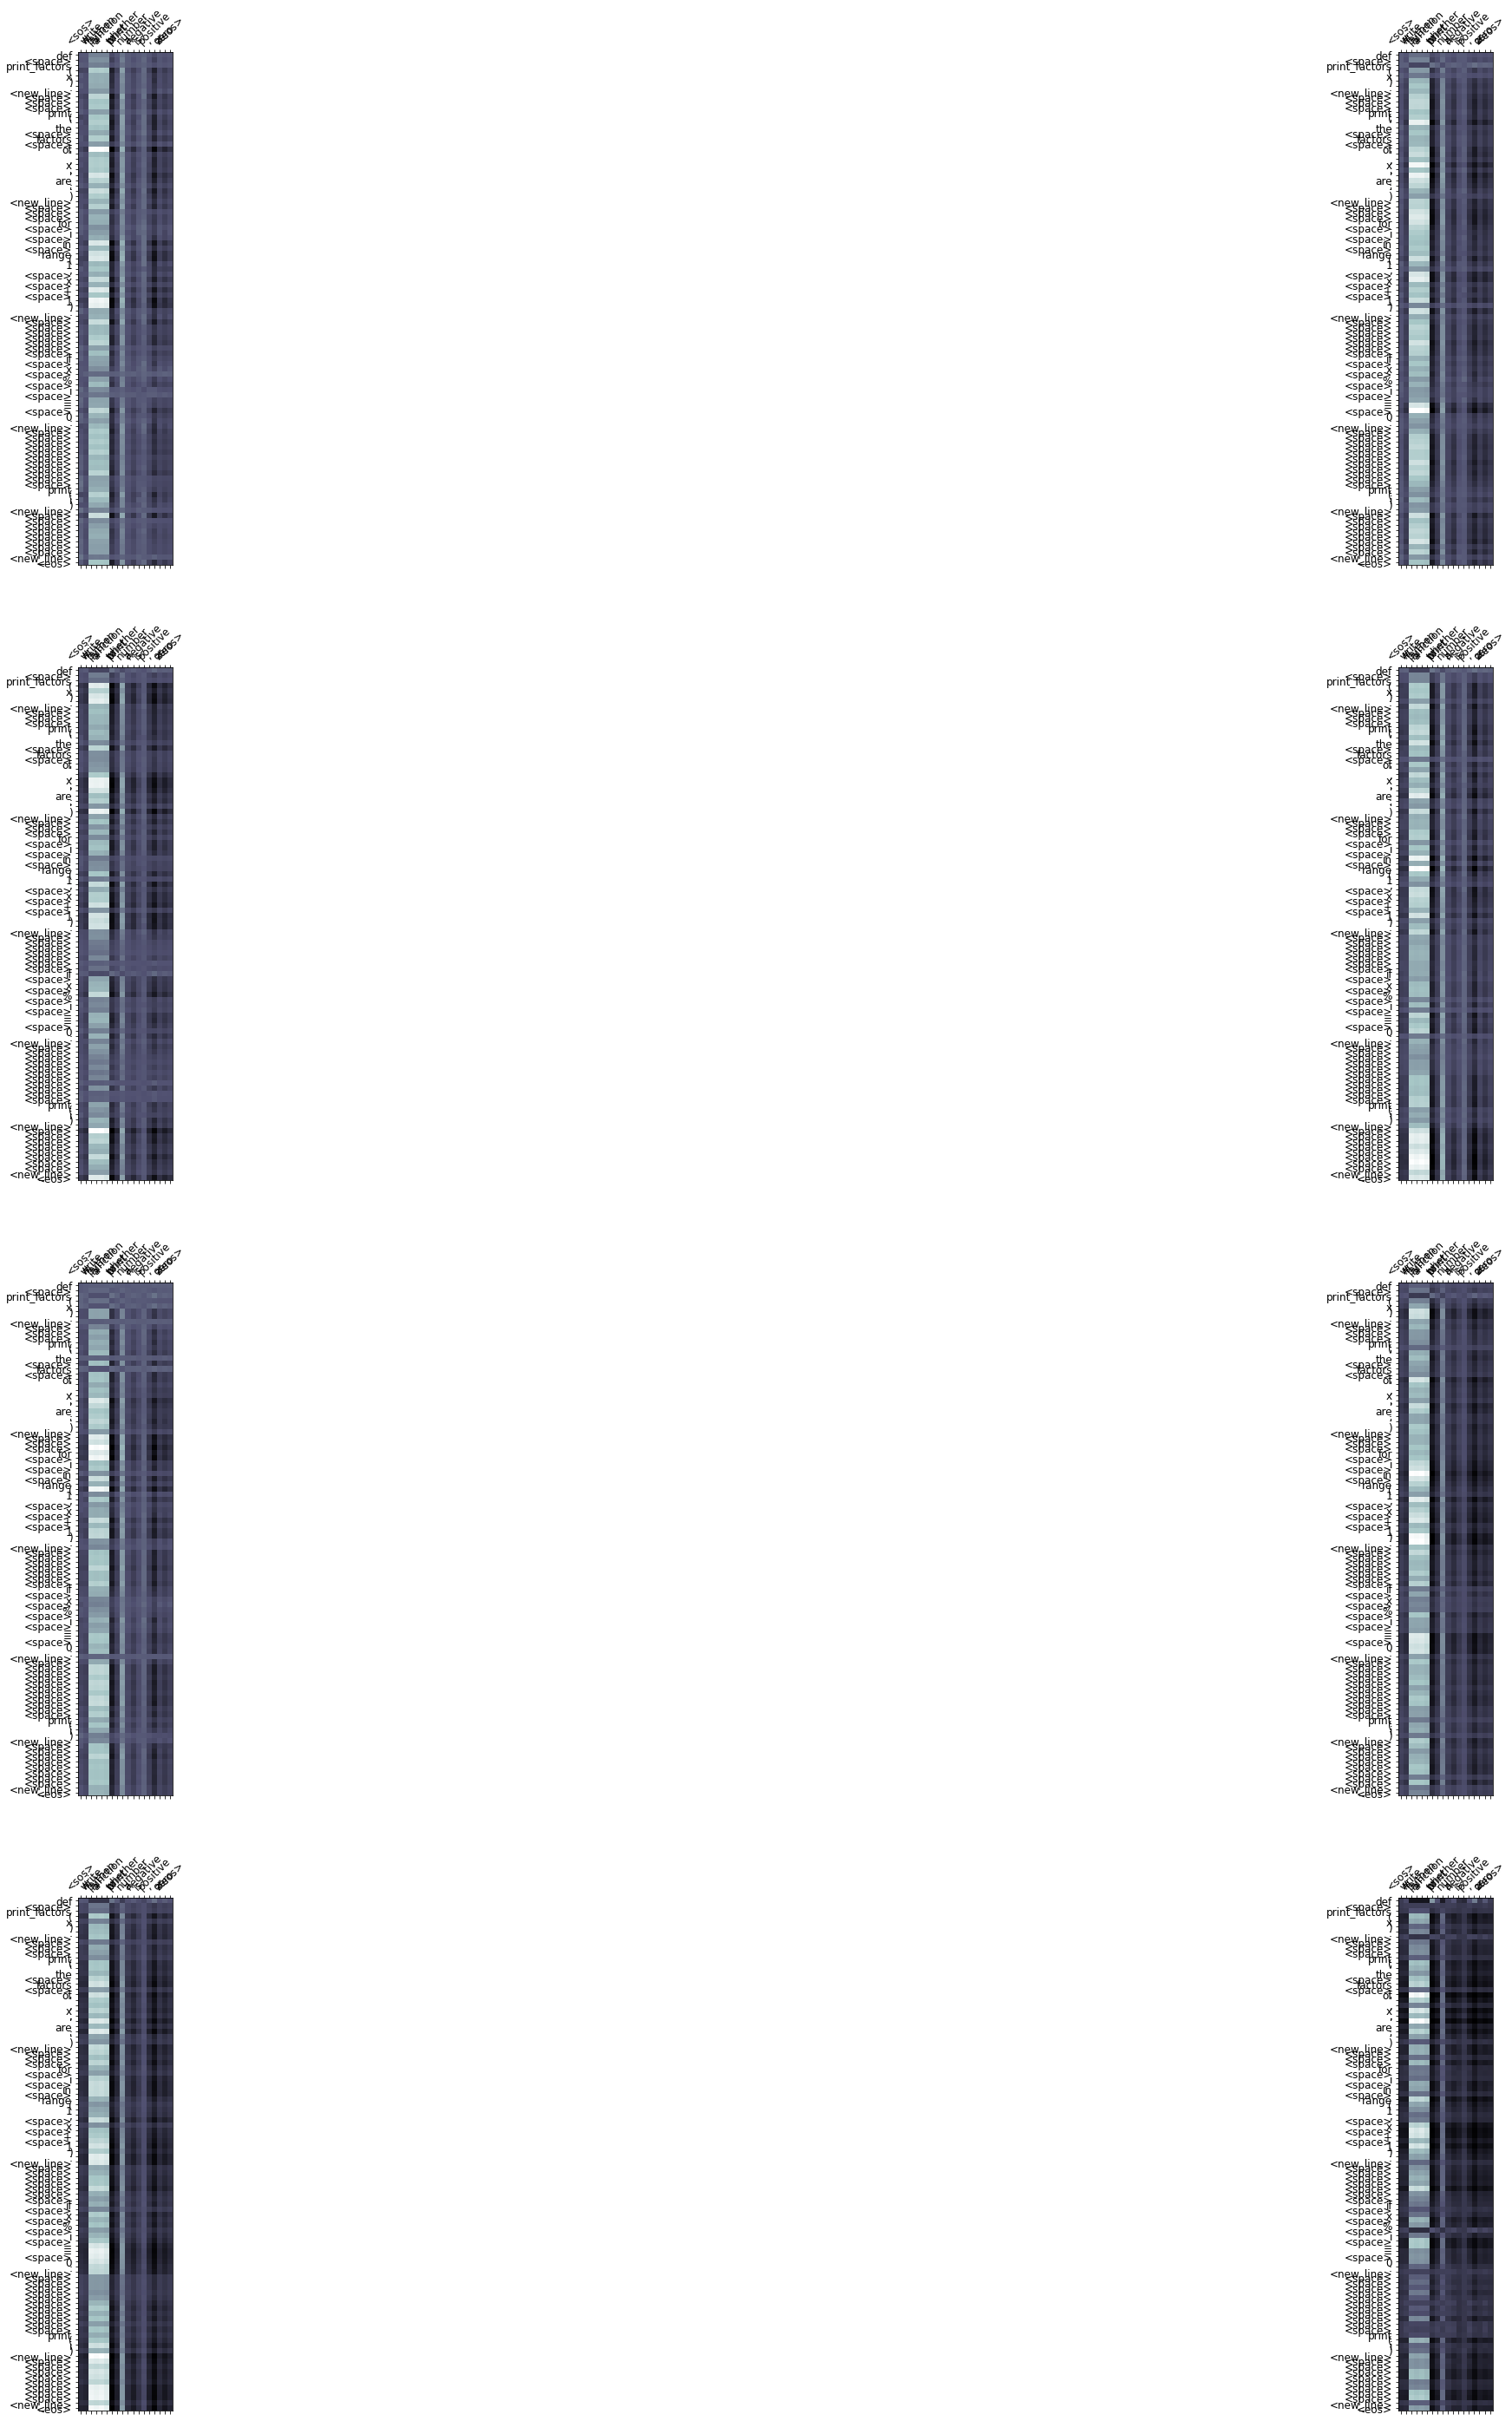

In [54]:
display_attention(src, translation, attention)


In [55]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['#', 'write', 'a', 'python', 'program', 'to', 'find', 'those', 'numbers', 'which', 'are', 'divisible', 'by', '7', 'and', 'multiple', 'of', '5', ',', 'between', '1500', 'and', '2700', 'and', 'print', 'the', 'result', '.']
trg = ['nl', '<space>', '=', '<space>', '[', ']', '<new_line>', 'for', '<space>', 'x', '<space>', 'in', '<space>', 'range', '(', '1500', ',', '<space>', '2700', ')', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'if', '<space>', '(', 'x', '%', '7', '=', '=', '0', ')', '<space>', 'and', '<space>', '(', 'x', '%', '5', '=', '=', '0', ')', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', '<space>', 'nl', '.', 'append', '(', 'str', '(', 'x', ')', ')', '<new_line>', 'print', '(', "'", '\\n', "'", '.', 'join', '(', 'nl', ')', ')', '<new_line>']


In [56]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['print', '(', "'", 'hello', '<space>', 'world', "'", ')', '<new_line>', '<eos>']


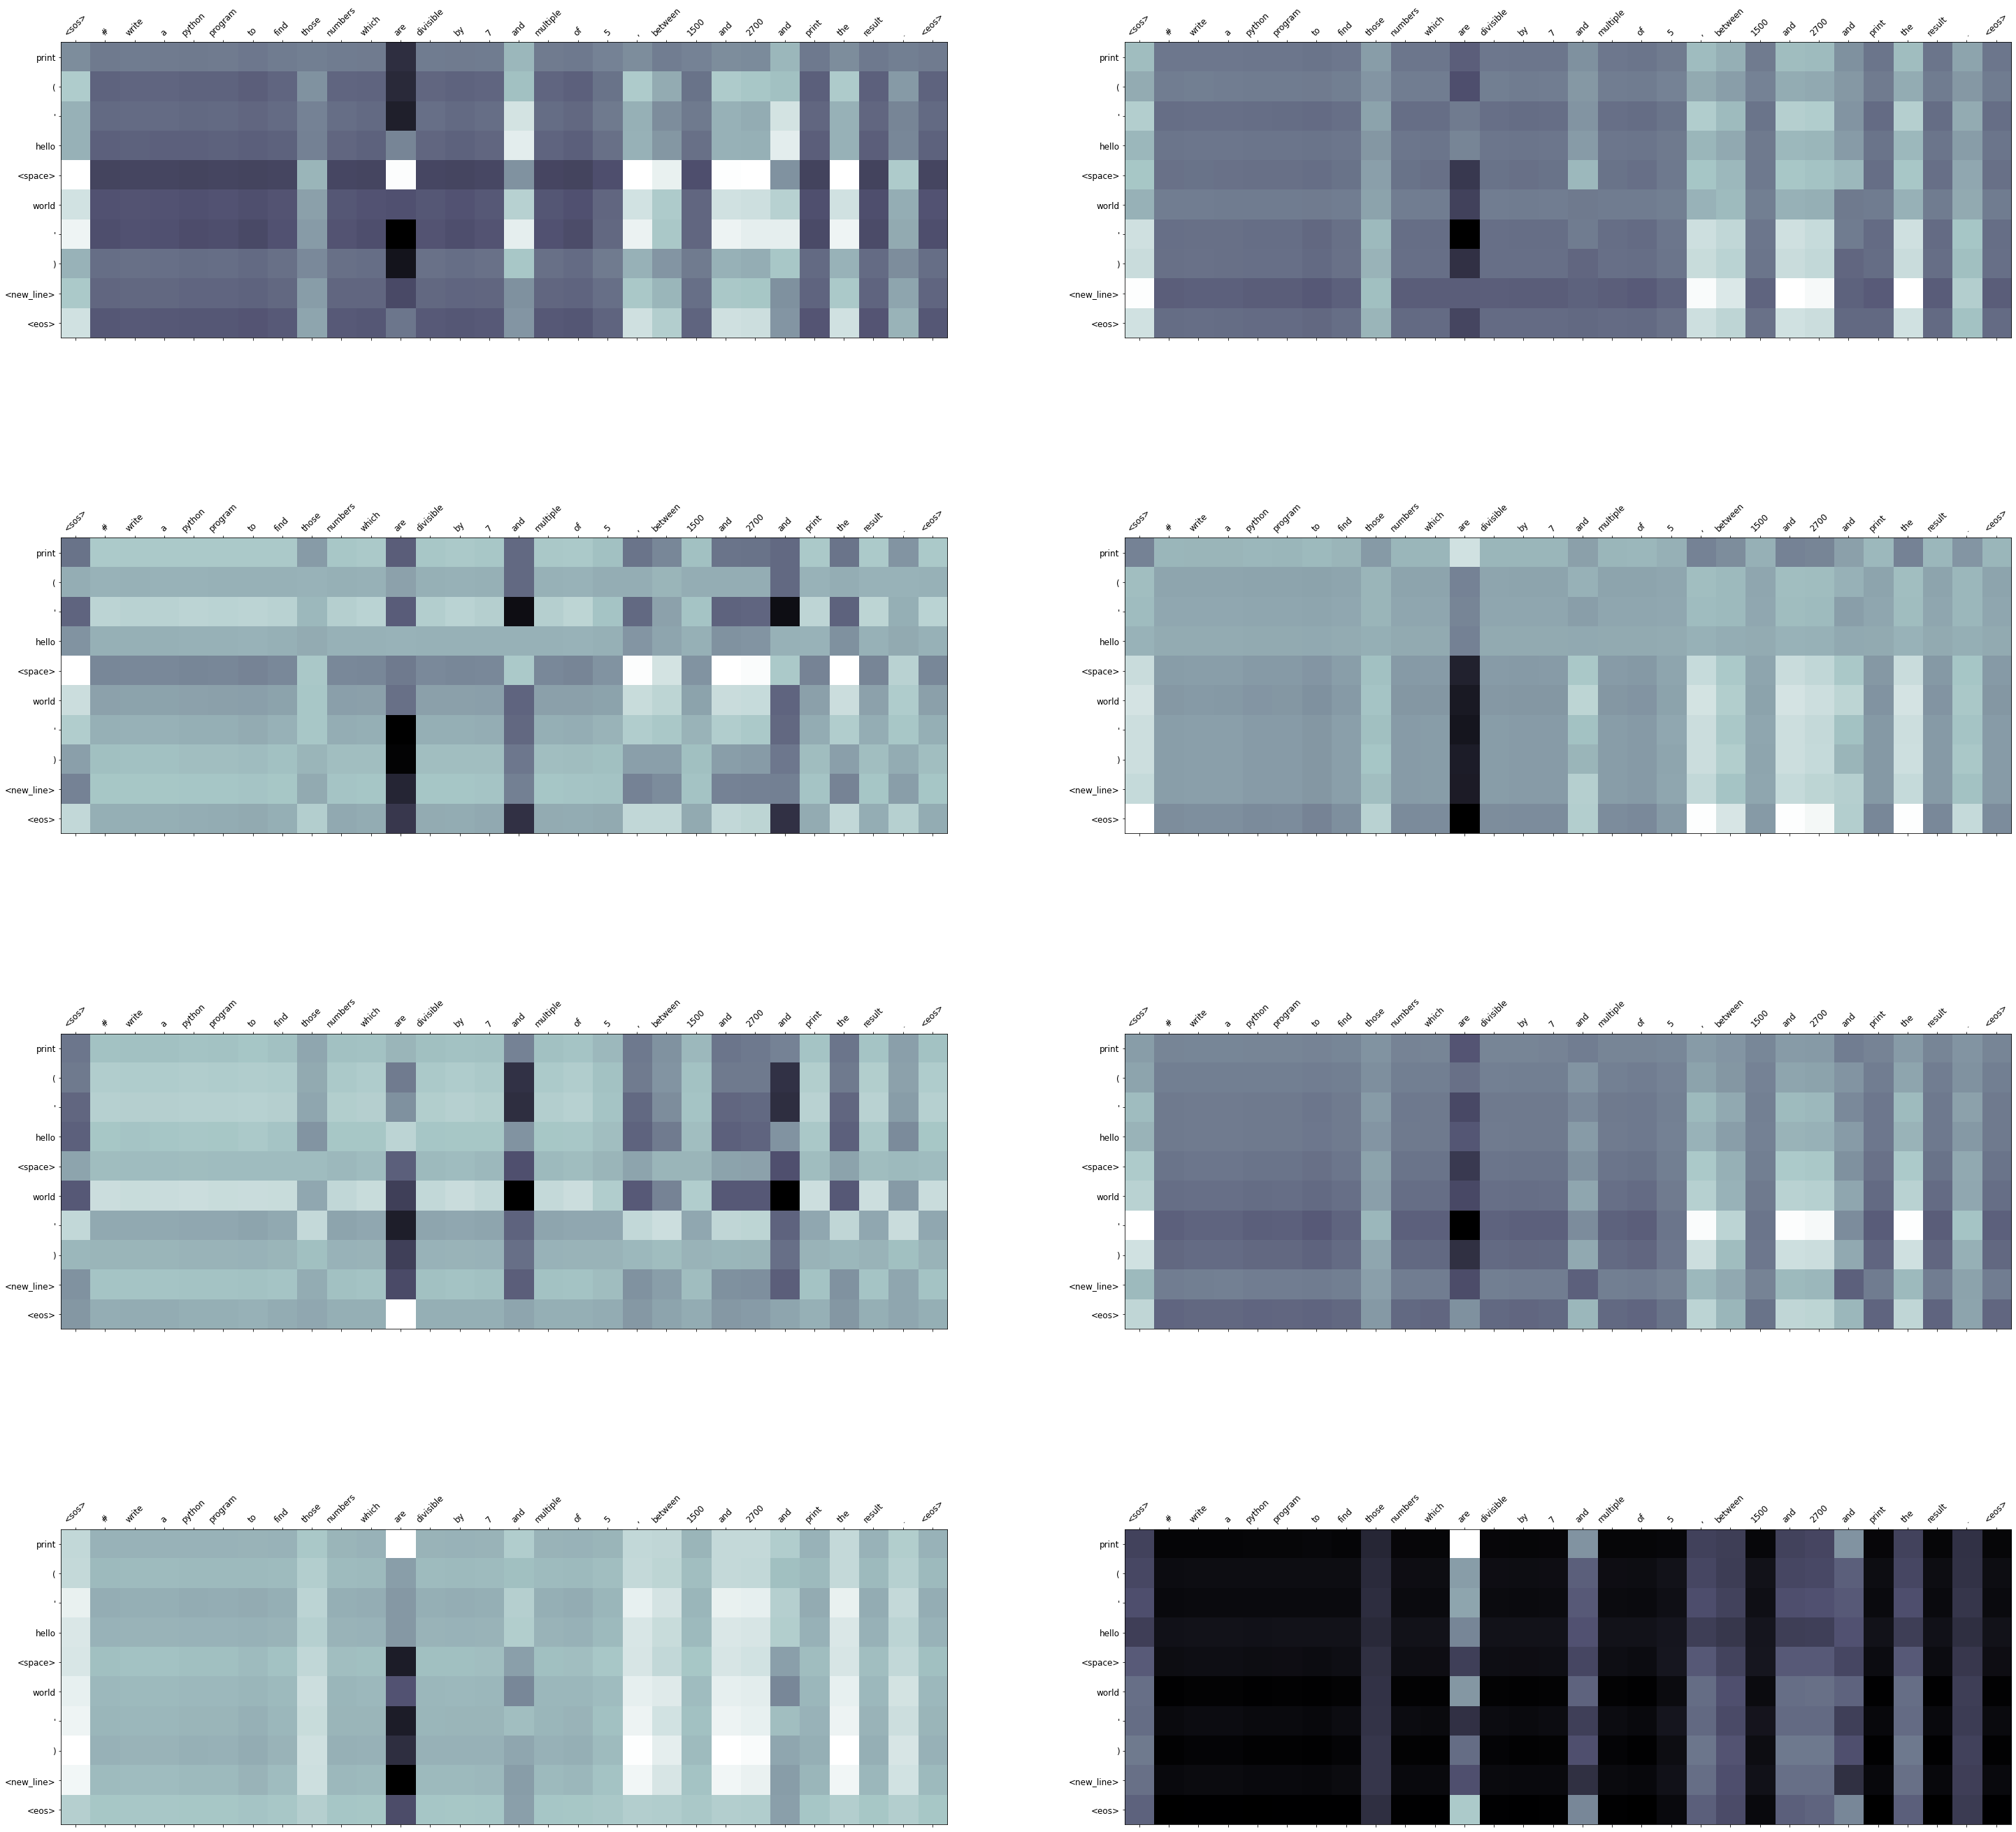

In [57]:
display_attention(src, translation, attention)


#**25 Examples to be predicted**

In [73]:
from random import randint
example_idxs = [randint(0, 300) for i in range (25)]
for example_idx in example_idxs:
  src = vars(train_data.examples[example_idx])['src']
  trg = vars(train_data.examples[example_idx])['trg']
  print('### Problem statement in English:')
  print(' '.join(src))
  print('### Ground Truth Python code:')

  print(''.join(trg).replace('<space>', ' ').replace('<new_line>', '\n'))

  print('### English to python prediction:')
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  print(translation)

### Problem statement in English:
# write a function to calculate the current in the curcit where the resistance is r and voltage is v
### Ground Truth Python code:
def cal_current(resistance:float, voltage:float)->float:
    return voltage/resistance

### English to python prediction:
['def', '<space>', 'cal_current', '(', 'resistance', ':', 'float', ',', '<space>', 'voltage', ':', 'float', ')', '-', '>', 'float', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'return', '<space>', 'voltage', '/', 'resistance', '<new_line>', '<eos>']
### Problem statement in English:
# write a python function to find the area of a circle , whose radius is given
### Ground Truth Python code:
def findarea(r): 
    pi = 3.142
    return pi * (r*r)

### English to python prediction:
['def', '<space>', 'findarea', '(', 'r', ')', ':', '<space>', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'pi', '<space>', '=', '<space>', '3', '.', '142', '<new_line>', '<space>', '<space>', '<spa

In [74]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 1700):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append(''.join (trg).replace ('<space>', ' ').replace ('<new_line>', '\n'))
    print ('done')
    print (pred_trgs[0])
    print (trgs[0])
    return bleu_score(pred_trgs, trgs)

In [76]:
bleau=calculate_bleu(test_data, SRC, TRG, model, device)
print(bleau)

done
['def', '<space>', 'cal_perimeter_triangle', '(', 's1', ',', 's2', ',', 's3', ')', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'return', '<space>', 's1', '+', 's2', '+', 's3', '<new_line>']
def file_read_from_head(fname, nlines):
    from itertools import islice
    with open(fname) as f:
      for line in islice(f, nlines):
        print(line)

0.0
